<a href="https://colab.research.google.com/github/YasiruMM/Medicine-Prediction-Grp-22/blob/main/XGBooster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/My Drive/DSGP/NoiseHandled1_MediTrack_Dataset.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
# Prepare feature (X) and target (Y) variables
X = df[['CV','Buffer Percentage','Sales_LOESS_Date',
        'Log_Retail_Price', 'Log_Purchase_Price', 'Log_Mean_Sales', 'Log_Buffer_Stock', 'Month', 'Year',
        'Disease Category', 'Drug Category', 'Drug Name']]

Y = df[['Log_Sales']]

In [ ]:
# Save 'Drug Name'& Disease Category before encoding
drug_names = X[['Drug Name']]
disease_categories = X[['Disease Category']]

In [ ]:
# Convert categorical variables into numerical labels using One-Hot Encoding
X = pd.get_dummies(X, columns=['Disease Category', 'Drug Category', 'Drug Name'], drop_first=True)

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [ ]:
# Convert to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [ ]:
# Set the model parameters
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',            # Evaluation metric: root mean square error
    'max_depth': 4,                   # Maximum tree depth
    'learning_rate': 0.03,             # Learning rate
    'colsample_bytree': 0.8,          # Column sampling rate
    'subsample': 0.9,                  # Subsample rate
    'reg_lambda': 10,                   # L2 regularization (Ridge)
    'reg_alpha': 2                      # L1 regularization (Lasso)
}

In [ ]:
# Train the model by getting involved with cross validation
num_boost_round = 100  # Number of boosting rounds
cv_results = xgb.cv(
    params=params,
    dtrain=xgb.DMatrix(X, label=Y),  # Use the entire dataset for CV
    num_boost_round=num_boost_round,
    nfold=5,  # Number of folds in cross-validation
    early_stopping_rounds=10,  # Stop early if the performance doesn't improve
    as_pandas=True,  # Returns the results as a pandas DataFrame
    verbose_eval=True  # Print progress
)
# Display cross-validation results
print(cv_results)


[0]	train-rmse:2.04196+0.01004	test-rmse:2.04205+0.04031
[1]	train-rmse:1.99171+0.00960	test-rmse:1.99206+0.03934
[2]	train-rmse:1.96803+0.00923	test-rmse:1.96887+0.03823
[3]	train-rmse:1.92059+0.00896	test-rmse:1.92168+0.03713
[4]	train-rmse:1.87440+0.00874	test-rmse:1.87561+0.03612
[5]	train-rmse:1.83017+0.00851	test-rmse:1.83162+0.03525
[6]	train-rmse:1.78697+0.00819	test-rmse:1.78853+0.03445
[7]	train-rmse:1.74506+0.00799	test-rmse:1.74688+0.03348
[8]	train-rmse:1.70684+0.00799	test-rmse:1.70875+0.03250
[9]	train-rmse:1.66778+0.00776	test-rmse:1.66977+0.03154
[10]	train-rmse:1.62991+0.00759	test-rmse:1.63222+0.03073
[11]	train-rmse:1.59336+0.00738	test-rmse:1.59590+0.02987
[12]	train-rmse:1.55820+0.00708	test-rmse:1.56106+0.02903
[13]	train-rmse:1.52416+0.00690	test-rmse:1.52726+0.02823
[14]	train-rmse:1.49087+0.00664	test-rmse:1.49412+0.02744
[15]	train-rmse:1.45925+0.00648	test-rmse:1.46284+0.02648
[16]	train-rmse:1.42850+0.00631	test-rmse:1.43258+0.02580
[17]	train-rmse:1.39847+

In [ ]:
#getting the best boosting round based on the evaluation metric
best_round = cv_results['test-rmse-mean'].idxmin()  # finding the best round with the minimum RMSE
print(f"Best boosting round: {best_round}")


Best boosting round: 99


In [ ]:
# training the final model by using the best boosting round
model = xgb.train(
    params=params,
    dtrain=xgb.DMatrix(X, label=Y),
    num_boost_round=best_round  # Train with the optimal number of boosting rounds
)


In [ ]:
# saving test dataset for future predictions
X_test_future=X_test.copy()




In [ ]:
import numpy as np
# loop XGBooster for 6 months predictions
future_results=pd.DataFrame()
for month in range(1,7):
  # Simulate the Date using Month and Year
  X_test_future['Date'] = pd.to_datetime(X_test_future[['Year', 'Month']].assign(Day=1))
  # Handle Month and Year updation
  X_test_future['Month']+=1
  X_test_future['Year']+= (X_test_future['Month'] > 12).astype(int) # handle Year overflow situations
  X_test_future['Month']=X_test_future['Month'] % 12 # Reset Months for exceeding 12 situations
  X_test_future['Month'].replace(0, 12, inplace=True)
  # Update the Date column
  X_test_future['Date'] = pd.to_datetime(X_test_future[['Year', 'Month']].assign(Day=1))

  X_test_future=X_test_future.drop(columns=['Date']) # Drop Month and Year from Original dataset.
  # prepare the dataset for predictions
  dtest_future = xgb.DMatrix(X_test_future)
  # Predict the next month's sales (in log scale)
  log_predictions_future = model.predict(dtest_future)

  # Convert log predictions back to original scale
  predictions_future = np.exp(log_predictions_future)


  # Dynamically update Mean Sales
  X_test_future['Log_Mean_Sales'] = np.log(
    (np.exp(X_test_future['Log_Mean_Sales']) * month + predictions_future) / (month + 1)
    )
  # Update Buffer Stock dynamically
  X_test_future['Log_Buffer_Stock'] = np.log(predictions_future *np.exp( X_test_future['Log_Buffer_Stock']))



  future_Month_Results=pd.DataFrame({
          'Disease Category': disease_categories.iloc[X_test_future.index]['Disease Category'],
          'Drug Name': drug_names.iloc[X_test_future.index]['Drug Name'],
          'Month': [month] * len(predictions_future),
          'Predicted Sales': predictions_future

      })

     # Concatenate instead of append
  future_results = pd.concat([future_results, future_Month_Results], ignore_index=True)




<ipython-input-42-af4622ebd445>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test_future['Month'].replace(0, 12, inplace=True)
<ipython-input-42-af4622ebd445>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [ ]:
print(future_results.head())

  Disease Category            Drug Name  Month  Predicted Sales
0         Diabetes  GLIPIZIDE (USV) 5MG      1        47.423820
1   Cardiovascular          TROKAN 75MG      1      1097.411011
2      Cholesterol        X-PLENDED 5MG      1        99.006752
3         Diabetes         GLIX 40 80MG      1       195.674316
4      Cholesterol          ATOGEN 10MG      1       691.689331


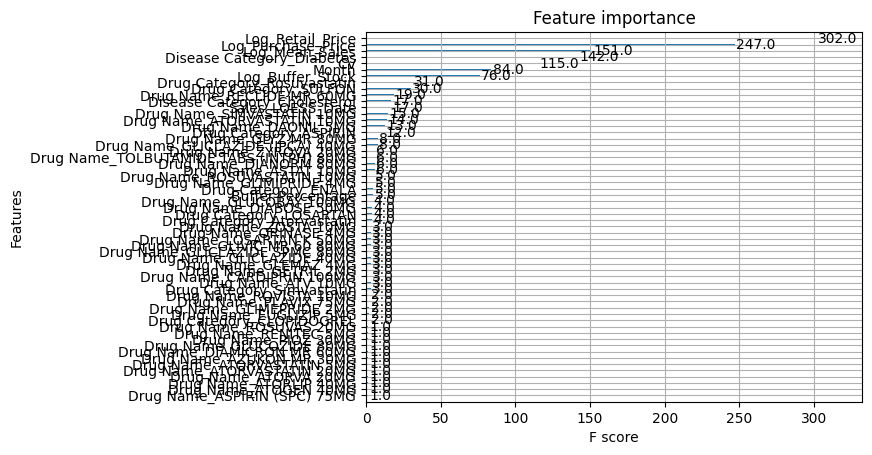

In [ ]:
# Getting feature importance scores from the trained model
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()


# R^2 and Coefficient of Variance Determination

In [ ]:
from sklearn.metrics import r2_score

# Calculate R² score
r2 = r2_score(y_test, predictions_future)
print(f"R²: {r2}")

R²: 0.9984869956970215


In [ ]:
import numpy as np

# Calculate Coefficient of Variation (CV)
cv =( np.std(predictions_future) / np.mean(predictions_future) )* 100
print(f"Coefficient of Variation (CV): {cv}%")

Coefficient of Variation (CV): 177.04731225967407%


In [ ]:
# # Make predictions
# predictions = model.predict(dtest)

# # Create a DataFrame with the predictions and drug names
# results = pd.DataFrame({
#     'Drug Name': drug_names.iloc[X_test.index]['Drug Name'],  # Map back to the original Drug Name
#     'Disease Category': disease_categories.iloc[X_test.index]['Disease Category'],  # Map back to the original Disease Category
#     'Predicted Sales': predictions
# })

In [ ]:
# Pivot the DataFrame so each drug has predictions in a single row
pivot_results = future_results.pivot_table(
    index=['Disease Category', 'Drug Name'],
    columns='Month',
    values='Predicted Sales'
).reset_index()

#Enhancing readability by renaming for all Predictions
pivot_results.columns = ['Disease Category', 'Drug Name', 'Prediction 1', 'Prediction 2', 'Prediction 3', 'Prediction 4', 'Prediction 5', 'Prediction 6']


In [ ]:
from google.colab import files
pivot_results.to_csv('Medicine predictions XGBooster.csv', index=False)
files.download('Medicine predictions XGBooster.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>